# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [145]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [6]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [25]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])


assert check_layer_gradient(ReLULayer(), X)

-0.5146019010431546 [[ 1.53249978  0.          0.27121913]
 [ 0.         -1.47066096  0.80562851]]
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [115]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

-0.0001392413345112451 [[-0.00199201  0.00069342  0.00160548]
 [-0.00020433 -0.00042334 -0.00078595]]
Gradient check passed!
-0.007500077696774054 [[-0.80459065  1.0931369  -1.75920352  1.42553744]
 [ 1.6091813  -2.18627379  3.51840704 -2.85107488]
 [ 1.10169564  1.24580067 -5.08655863  3.23106459]]
Gradient check passed!
-0.0017260656328064502 [-1.37087222 -1.65236023 -0.15841147 -0.67733355]
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [116]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
2.3036642740513136 [[ 2.71588778e-05  3.02080563e-06  1.53953838e-07]
 [ 6.07403604e-06  1.20101283e-06  1.83439697e-07]
 [-5.33421207e-05 -3.02735216e-06  5.21694187e-07]
 ...
 [ 1.02044063e-04  4.25915749e-06 -1.43254031e-06]
 [ 6.42201363e-05  1.34577582e-06 -1.28006507e-06]
 [ 3.58459824e-06 -3.26818827e-06 -1.01961477e-06]]
Gradient check passed!
Checking gradient for B1
2.30366427406151 [-7.37779783e-04 -3.36566043e-05  9.54537769e-06]
Gradient check passed!
Checking gradient for W2
2.303664273966056 [[ 0.00161744  0.00161753  0.00161564  0.0016163   0.00161712  0.00161437
   0.00161417  0.0016173   0.00161764 -0.0145475 ]
 [ 0.00051132  0.00051135  0.00051075  0.00051096  0.00051122  0.00051035
   0.00051029  0.00051128  0.00051138 -0.0045989 ]
 [ 0.00011767  0.00011768  0.00011754  0.00011759  0.00011765  0.00011745
   0.00011744  0.00011766  0.00011769 -0.00105838]]
Gradient check passed!
Checking gradient for B2
2.303664284549819 [ 0.10007633  0.10008

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [125]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
2.3933750495538626 [[ 0.02027072  0.00564936  0.00421046]
 [-0.02900239 -0.00411089 -0.00584951]
 [-0.03206649 -0.02235545  0.01793461]
 ...
 [-0.02537408  0.01072357  0.0084676 ]
 [ 0.03066695  0.00824387 -0.01201462]
 [ 0.02014158 -0.04254118  0.02939073]]
Gradient check passed!
Checking gradient for B1
2.393374756646522 [ 0.0093345  -0.01643931  0.00552571]
Gradient check passed!
Checking gradient for W2
2.3933747023894 [[-0.01174064  0.02709303 -0.00854755 -0.00322643 -0.00487167  0.00445475
   0.00765399  0.01444248 -0.0034767   0.00247216]
 [ 0.0387815  -0.0015507  -0.00992563 -0.02318914 -0.00999292 -0.00066845
  -0.00863941  0.01674501 -0.00036174 -0.02171596]
 [ 0.02440192  0.02507267 -0.01124602 -0.01141203  0.00269443  0.01403875
  -0.00538512 -0.03277587  0.03127251 -0.01519839]]
Gradient check passed!
Checking gradient for B2
2.393374855373259 [ 0.0917046   0.10352838  0.11284574  0.07804399  0.09655445  0.10119218
  0.05284246  0.11805752  0.07651

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [126]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [134]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-1)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.234589, Train accuracy: 0.199000, val accuracy: 0.207000
Loss: 2.117092, Train accuracy: 0.310889, val accuracy: 0.314000
Loss: 2.196652, Train accuracy: 0.406333, val accuracy: 0.401000
Loss: 1.963867, Train accuracy: 0.467889, val accuracy: 0.474000
Loss: 1.759799, Train accuracy: 0.511000, val accuracy: 0.527000
Loss: 1.810178, Train accuracy: 0.535222, val accuracy: 0.528000
Loss: 1.579139, Train accuracy: 0.563667, val accuracy: 0.562000
Loss: 1.696301, Train accuracy: 0.549000, val accuracy: 0.550000
Loss: 1.781856, Train accuracy: 0.548333, val accuracy: 0.550000
Loss: 1.795437, Train accuracy: 0.579444, val accuracy: 0.561000
Loss: 1.784782, Train accuracy: 0.582111, val accuracy: 0.573000
Loss: 1.575877, Train accuracy: 0.590667, val accuracy: 0.596000
Loss: 1.838572, Train accuracy: 0.597444, val accuracy: 0.606000
Loss: 2.088101, Train accuracy: 0.594222, val accuracy: 0.589000
Loss: 1.513619, Train accuracy: 0.590889, val accuracy: 0.583000
Loss: 2.076604, Train acc

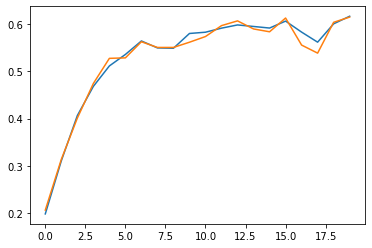

In [135]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [146]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.301499, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275931, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310207, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290505, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323742, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230210, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278356, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.199329, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268487, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.364486, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.199324, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253198, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286931, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316432, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [151]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.066856, Train accuracy: 0.197333, val accuracy: 0.207000
Loss: 1.552011, Train accuracy: 0.400111, val accuracy: 0.405000
Loss: 1.283972, Train accuracy: 0.550000, val accuracy: 0.566000
Loss: 1.568589, Train accuracy: 0.633111, val accuracy: 0.632000
Loss: 1.410308, Train accuracy: 0.676667, val accuracy: 0.656000
Loss: 0.844700, Train accuracy: 0.708222, val accuracy: 0.687000
Loss: 0.807679, Train accuracy: 0.719222, val accuracy: 0.694000
Loss: 1.036801, Train accuracy: 0.726222, val accuracy: 0.683000
Loss: 0.770682, Train accuracy: 0.777222, val accuracy: 0.722000
Loss: 0.769781, Train accuracy: 0.779222, val accuracy: 0.712000
Loss: 0.927714, Train accuracy: 0.772556, val accuracy: 0.704000
Loss: 0.623606, Train accuracy: 0.783444, val accuracy: 0.721000
Loss: 0.915004, Train accuracy: 0.812667, val accuracy: 0.736000
Loss: 1.646917, Train accuracy: 0.785556, val accuracy: 0.731000
Loss: 0.611142, Train accuracy: 0.825333, val accuracy: 0.739000
Loss: 0.725620, Train acc

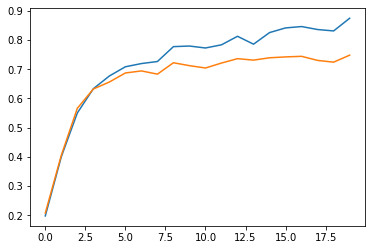

In [152]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [173]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335422, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.335836, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306164, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.317203, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.292860, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.241438, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.261541, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.178510, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.146939, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.390869, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.155585, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.846927, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.118116, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.148068, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.983481, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.977429, Train acc

Loss: 1.113337, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.633323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.212356, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.020956, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.198218, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.061999, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.113001, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.095860, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.326146, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.268917, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.631590, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.352995, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.334259, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.325281, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.502998, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.235834, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [191]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 1000, reg = 1e-4)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=30*1e-1, num_epochs=20, batch_size=100)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.303067, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.289460, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.263259, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.215708, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.109848, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.889864, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.702000, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.512528, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.454390, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 1.653913, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.070541, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.077149, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.701216, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.521985, Train accuracy: 0.933333, val accuracy: 0.066667
Loss: 0.389018, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.266268, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [200]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=100)

loss_history, train_history, val_history = trainer.fit()

print('best validation accuracy achieved: %f' % max(val_history))

Loss: 2.239107, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200414, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231689, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.124754, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.221385, Train accuracy: 0.202778, val accuracy: 0.214000
Loss: 2.055921, Train accuracy: 0.261222, val accuracy: 0.260000
Loss: 2.042444, Train accuracy: 0.278333, val accuracy: 0.277000
Loss: 1.848463, Train accuracy: 0.313222, val accuracy: 0.323000
Loss: 2.004664, Train accuracy: 0.376556, val accuracy: 0.369000
Loss: 1.558758, Train accuracy: 0.406111, val accuracy: 0.414000
Loss: 1.675841, Train accuracy: 0.459333, val accuracy: 0.445000
Loss: 1.450256, Train accuracy: 0.523556, val accuracy: 0.506000
Loss: 1.313915, Train accuracy: 0.569778, val accuracy: 0.564000
Loss: 1.241962, Train accuracy: 0.601111, val accuracy: 0.589000
Loss: 1.407942, Train accuracy: 0.625222, val accuracy: 0.623000
Loss: 1.186986, Train acc

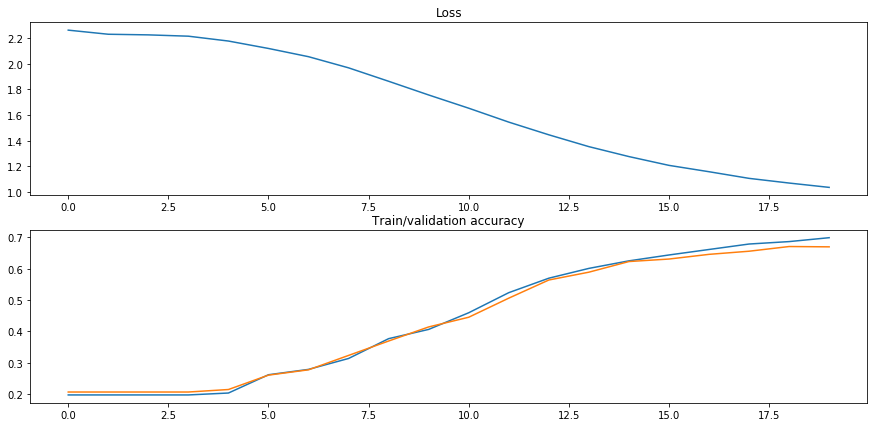

In [202]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)
best_classifier = model

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [203]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.635000
